# Chapter 1: GemPy Basic

In this first example, we will show how to construct a first basic model and the main objects and functions. First we import gempy:

In [1]:
# These two lines are necessary only if gempy is not installed
import sys, os
sys.path.append("../..")

# Importing gempy
import gempy as gp

# Embedding matplotlib figures into the notebooks
%matplotlib inline

# Aux imports
import numpy as np

../../gempy/posterior_analysis.py:28: UserWarning: pymc (v3) package is not installed. No support for stochastic simulation posterior analysis.
  warnings.warn("pymc (v3) package is not installed. No support for stochastic simulation posterior analysis.")


In [2]:
if True:
    # Load data
    geo_data_g = gp.read_pickle('models/graben.pickle')
else:
    # Importing the data from csv files and settign extent and resolution
    geo_data_g = gp.create_data([0,1000,0,1000,-1000,0],[ 60,60,60])

In [3]:
geo_data_g.set_series({'Fault1':'fault_left', 'Fault2':'fault_right',
                    'Lithologies':['sediment1', 'sediment2', 'sediment3']})
geo_data_g.update_df()

In [4]:
# Save data
#gp.data_to_pickle(geo_data_g, path='models/graben')

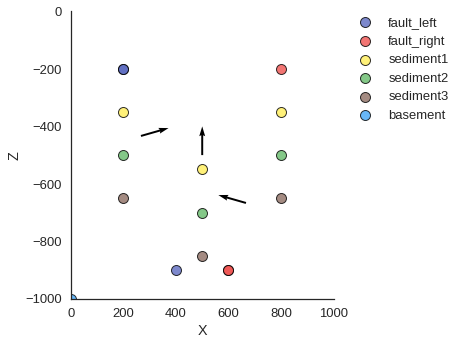

In [5]:
gp.plotting.plot_data(geo_data_g)

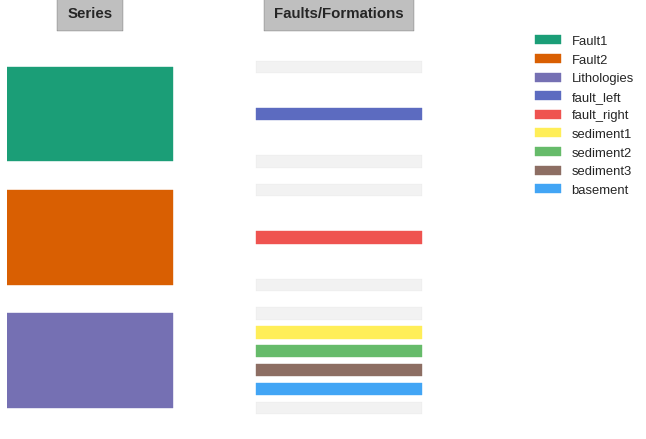

In [6]:
gp.get_sequential_pile(geo_data_g)

In [7]:
gravity=True

if gravity is True:
    # Set densites
    geo_data_g.set_formations(formation_values=np.array([0,1, 2.61,2.92,3.1, 2.61]))
    # Compile                                           ],
    interp_data = gp.InterpolatorData(geo_data_g, output='gravity', compile_theano=True,
                                     theano_optimizer='fast_run')
    # Create airborn plane and decomposing z
    gp.set_geophysics_obj(interp_data,
                      [350,650, 350,650, 350, 750],
                      [20, 20], range_max = 300)
    gp.precomputations_gravity(interp_data, 25)
else:
    interp_data = gp.InterpolatorData(geo_data_g, output='geology', compile_theano=True,
                                      theano_optimizer='fast_run')                                            

Compiling theano function...
Compilation Done!
Level of Optimization:  fast_run
Device:  cpu
Precision:  float32
Number of faults:  2


In [8]:
if gravity is True:
    sol = gp.compute_model(interp_data, output='gravity')
else:
    sol = gp.compute_model(interp_data, output='geology')

In [24]:
# If you need to change someting in geo_data

geo_data_g.update_df()
interp_data.update_interpolator(geo_data_g)

In [12]:
geo_data_g.formations

,value,formation_number
fault_left,0.00,1
fault_right,1.00,2
sediment1,2.61,3
sediment2,2.92,4
sediment3,3.10,5
basement,2.61,6


In [14]:
sol = gp.compute_model(interp_data)
np.unique(sol[0][0])

array([2.61, 2.92, 3.1 ], dtype=float32)

../../gempy/gempy_front.py:953: FutureWarning: gempy plotting functionality will be moved in version 1.2, use gempy.plotting module instead
  "use gempy.plotting module instead", FutureWarning)


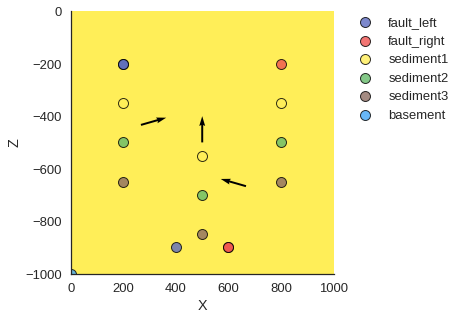

In [10]:
gp.plot_section(geo_data_g, sol[0][0], 30, plot_data=True)

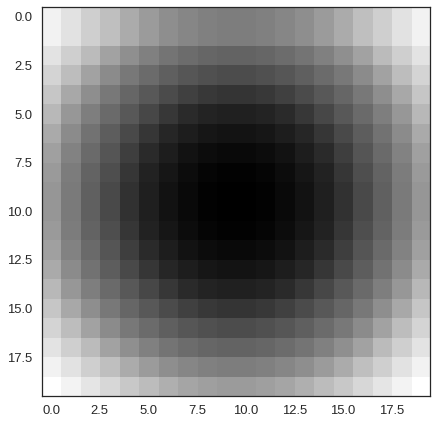

In [15]:
# Plot gravity
import matplotlib.pyplot as plt
plt.imshow(sol[2].reshape(20,20))

In [23]:
# We set the real gravity
original_grav = sol[2]

In [30]:
gp.plot_surfaces_3D(geo_data, ver, sim)

In [18]:
import copy
# First we extract from our original intep_data object the numerical data that is necessary for the interpolation.
# geo_data_stoch is a pandas Dataframe

# This is the inital model so it has to be outside the stochastic frame
interp_data.update_interpolator(geo_data_g)

geo_data_stoch_init = copy.deepcopy(interp_data.geo_data_res)

In [19]:
import pymc 
interface_Z_modifier = []

# We rescale the standard deviation
std = 50./interp_data.rescaling_factor

# loop over the unique group id's and create a pymc.Normal distribution for each
for gID in ['sediment1', 'sediment2','sediment3']:
    stoch = pymc.Normal(gID+'_stoch', 0, 1./std**2)
    interface_Z_modifier.append(stoch)

In [20]:
@pymc.deterministic(trace=True)
def input_data(value = 0, 
               interface_Z_modifier = interface_Z_modifier,
               geo_data_stoch_init = geo_data_stoch_init,
               verbose=0):
    # First we extract from our original intep_data object the numerical data that is necessary for the interpolation.
    # geo_data_stoch is a pandas Dataframe
 #   geo_data_stoch = gp.get_data(interp_data_original.geo_data_res, numeric=True)

    geo_data_stoch = gp.get_data(geo_data_stoch_init, numeric=True)
    # Now we loop each id which share the same uncertainty variable. In this case, each layer.
    for e, gID in enumerate(['sediment1', 'sediment2','sediment3']):
        # First we obtain a boolean array with trues where the id coincide
        sel = gp.get_data(interp_data.geo_data_res, verbosity=2)['formation'] == gID
        
        # We add to the original Z value (its mean) the stochastic bit in the correspondant groups id 
        geo_data_stoch.loc[sel, 'Z']  += np.array(interface_Z_modifier[e])
        
    if verbose > 0:
        print(geo_data_stoch)
    
    # then return the input data to be input into the modeling function. Due to the way pymc2 stores the traces
    # We need to save the data as numpy arrays
    return [geo_data_stoch.xs('interfaces')[["X", "Y", "Z"]].values, geo_data_stoch.xs('orientations').values]

In [21]:
@pymc.deterministic(trace=True)
def gempy_model(value=0,
                input_data=input_data, verbose=True):
    
    # modify input data values accordingly
    interp_data.geo_data_res.interfaces[["X", "Y", "Z"]] = input_data[0]
    
    # Gx, Gy, Gz are just used for visualization.
    # The theano function gets azimuth dip and polarity!!!
    interp_data.geo_data_res.orientations[["G_x", "G_y", "G_z", "X", "Y", "Z",
                                           'dip', 'azimuth', 'polarity']] = input_data[1]
    interp_data.update_interpolator()
    try:
        # try to compute model
        lb, fb, grav = gp.compute_model(interp_data, output='gravity')
        if False:
            gp.plotting.plot_section(interp_data.geo_data_res, lb[0], 0, plot_data=True)
           # gp.plot_data(interp_data.geo_data_res, direction='y')

        return lb, fb, grav, interp_data.potential_at_interfaces
    
    except np.linalg.linalg.LinAlgError as err:
        # if it fails (e.g. some input data combinations could lead to 
        # a singular matrix and thus break the chain) return an empty model
        # with same dimensions (just zeros)
        if verbose:
            print("Exception occured.")
        return np.zeros_like(lith_block), np.zeros_like(fault_block)

In [24]:
if likelihood=True:
    @pymc.deterministic
    def e_sq(value = original_grav, model_grav = gempy_model[2], verbose = 0):
        square_error =  np.sqrt(np.sum((value*10**-7 - (model_grav*10**-7))**2)) 
      #  print(square_error)
        return square_error

    @pymc.observed
    def inversion(value = 1, e_sq = e_sq):
        return pymc.half_cauchy_like(e_sq,0,0.1)

In [25]:
# We add all the pymc objects to a list
params = [input_data, gempy_model,  *interface_Z_modifier,
          e_sq, inversion
         ] 

# We create the pymc model i.e. the probabilistic graph
model = pymc.Model(params)

In [26]:
# Change the name here
runner = pymc.MCMC(model, db="hdf5", dbname="data/graben_like.hdf5")

In [27]:
likelihood=True
if likelihood is True:
    runner.use_step_method(pymc.AdaptiveMetropolis, params, delay=1000)
    runner.sample(iter = 3000, burn=1000, thin=20, tune_interval=1000, tune_throughout=True)
else:
    runner.sample(iter = 200, burn=0)

 [-----------------100%-----------------] 3001 of 3000 complete in 4771.7 sec

### Error Propagation

In [36]:
db = pymc.database.hdf5.load('data/graben_error1.hdf5')
gmodels_e = db.trace('gempy_model')[:]

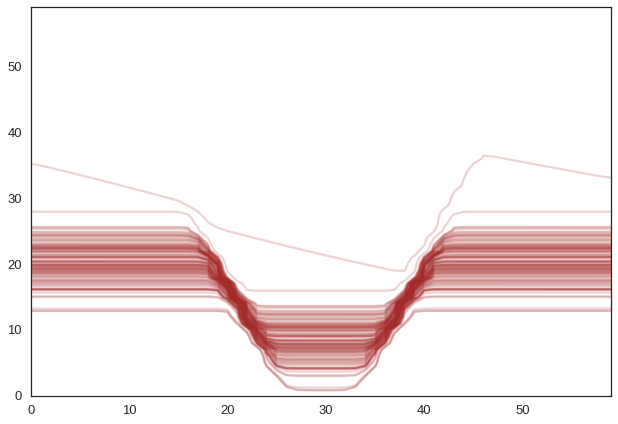

In [39]:
from scipy.ndimage.filters import gaussian_filter

for i in range(100):
    l =  gmodels_e[i][-1][-1,4:5]
    l.sort()
    data = gaussian_filter(gmodels_e[i][0][1].reshape(geo_data_g.resolution)[:,30,:].T, 0.7)

    plt.contour(data, levels = l,
                colors = ['brown', 'green','yellow'], alpha=.2 )

## Inference

In [28]:
db = pymc.database.hdf5.load('data/graben_like.hdf5')
gmodels = db.trace('gempy_model')[:]

In [31]:
gmodels.shape

(100, 4)

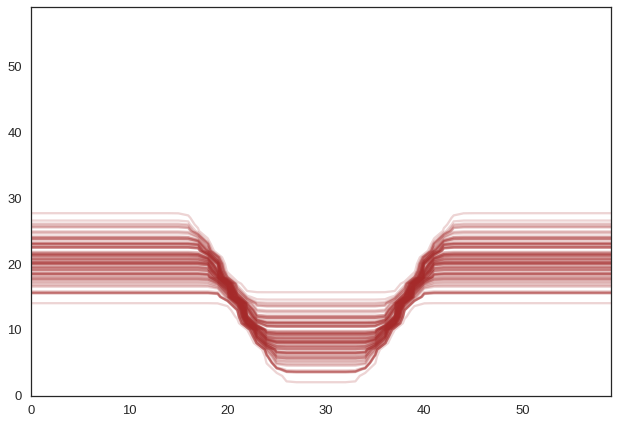

In [35]:
from scipy.ndimage.filters import gaussian_filter

for i in range(100):
    l =  gmodels[i][-1][-1,2:3]
    l.sort()
    data = gaussian_filter(gmodels[i][0][1].reshape(geo_data_g.resolution)[:,30,:].T, 0.7)

    plt.contour(data, levels = l,
                colors = ['brown', 'green','yellow'], alpha=.2 )